# Задание 4

Для каждой функции:

* исследуйте сходимость градиентного спуска с постоянным шагом, сравните полученные результаты для выбранных функций;
* сравните эффективность градиентного спуска с использованием одномерного поиска с точки зрения количества вычислений минимизируемой функции и ее градиентов;
* исследуйте работу методов в зависимости от выбора начальной точки;
* исследуйте влияние нормализации (scaling) на сходимость на примере масштабирования осей плохо обусловленной функции;
* в каждом случае нарисуйте графики с линиями уровня и траекториями методов;

## Инициализация

### Импорт библиотек

In [121]:
# Для графиков и прочего
import numpy as np
import scipy
from matplotlib import cm
import matplotlib.pyplot as plt
import math

# Для таблиц
import csv 

# Для работы с файлами
import os

# Для progress bar
from tqdm import tqdm

%matplotlib inline
plt.style.use('fivethirtyeight')

### Градиент

In [122]:
def grad(f, x, delta=1e-9):
    """
    Функция вычисления градиента в заданной точке с константной точностью.

    Аргументы:
    f -- функция
    x -- точка

    Возвращает:
    ans -- градиент функции в точке x
    """

    n = len(x)
    xd = np.copy(x)
    ans = np.zeros(n)

    for i in range(n):
        xd[i] += delta
        ans[i] = np.divide(f(xd) - f(x), delta)
        xd[i] -= delta

    return ans

### Градиентный спуск

In [123]:
def gradient_descent(f, x0, lr_search_func, num_iterations = 1000, eps = 1e-6, step_size = 1, minimum = 0, apply_min = False):
    """
    Функция вычисления градиентного спуска c заданной функцией поиска коэффициента обучения.

    Аргументы:
    f -- функция
    x0 -- начальная точка
    ----------------------------------------------------------------------------
    lr_search_func -- функция поиска оптимального коэффициента обучения (learning rate)
        Аргументы:
        f -- функция
        a -- левая граница интервала
        b -- правая граница интервала
        eps -- точность поиска

        Возвращает:
        x -- точка минимума функции
    ----------------------------------------------------------------------------
    eps -- точность поиска
    num_iterations -- количество итераций
    step_size -- размер шага

    Возвращает:
    points -- массив оптимальных на каждом шаге точек
    """
    def lineSearch(x, d):
        fd = lambda alpha: f(x - alpha*d)
        alpha = lr_search_func(fd, 0, 1, eps)
        return alpha

    x = np.copy(x0)
    points = np.array([x])
    for i in range(num_iterations):
        if apply_min and abs(f(x) - minimum) < eps:
            break

        grad_x = grad(f, x);
        x = x - grad_x * lineSearch(x, grad_x) * step_size
        points = np.vstack([points, x])
    return points

def dichotomy_search(f, a, b, eps=1e-6):
    """
    Метод дихотомии для поиска минимума функции f на интервале [a,b] с точностью eps

    Аргументы:
    f -- функция
    a -- начальная точка интервала
    b -- конечная точка интервала
    eps -- точность поиска

    Возвращает:
    x -- точка минимума функции
    """
    while b - a > eps:
        c = (a + b) / 2
        if f(c - eps) < f(c + eps):
            b = c
        else:
            a = c
    return (a + b) / 2

def gradient_descent_constant(f, x0, lr=0.01, num_iterations=1000, minimum=0, apply_min=False, eps=1e-6):
    """
    Градиентный спуск с постоянным шагом.

    Аргументы:
    f -- функция
    x0 -- начальная точка
    lr -- постоянный коэффициент обучения (learning rate)
    num_iterations -- количество итераций

    Возвращает:
    gradient_descent(...)
    """
    def const_lr(f, a, b, eps=1e-6):
        return lr
    
    return gradient_descent(f, x0, const_lr, num_iterations, minimum=minimum, apply_min=apply_min, eps=eps)

def gradient_descent_dichotomy(f, x0, num_iterations=1000, eps=1e-6, step_size=0.01, minimum=0, apply_min=False):
    """
    Градиентный спуск на основе метода дихотомии

    Аргументы:
    f -- функция
    x0 -- начальная точка
    num_iterations -- количество итераций
    eps -- точность поиска
    step_size -- размер шага
    
    Возвращает:
    gradient_descent(...)
    """

    return gradient_descent(f, x0, dichotomy_search, num_iterations, eps, step_size, minimum=minimum, apply_min=apply_min)

### 3D визуализация функции

In [124]:
def print_f(elev=30, azim=60):
  # Создание фигуры и трехмерной оси
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')

  # Установка угол обзора
  ax.view_init(elev=elev, azim=azim)

  # Построение поверхности
  ax.plot_surface(X, Y, Z)

  # Построение начальной точки
  ax.plot(x0[0], x0[1], f(x0), 'ro', label='Начальная точка')

  # Установка отступа между графиком и значениями осей
  ax.tick_params(pad=10)

  # Добавление легенды
  plt.legend(loc='upper left')

  # Установка размера шрифта для подписей осей
  ax.tick_params(axis='x', labelsize=10)
  ax.tick_params(axis='y', labelsize=10)
  ax.tick_params(axis='z', labelsize=10)

  # Добавление заголовка и подписей осей
  plt.title('График функции c начальной точкой')
  ax.set_xlabel('Ось X', labelpad=20.0)
  ax.set_ylabel('Ось Y', labelpad=20.0)
  ax.set_zlabel('Ось f(x, y)', labelpad=20.0)

  # Отображение графика
  plt.show()

### Линии уровня и градиент

In [125]:
def print_lines_grad(list_result, list_label, title='Градиентный спуск на уровнях функции', filename='', filename_extension='.png', dpi=1024):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111)

  for i in range(len(list_result)):
    levels=np.unique(sorted([f(p) for p in list_result[i]]))
    ax.contour(X, Y, Z, levels=levels, colors='red', antialiased=True, linewidths=1.0)

  for i in range(len(list_result)):
    x = list_result[i][:, 0]
    y = list_result[i][:, 1]
    ax.plot(x, y, marker='.', markersize=10, markerfacecolor='black', label=list_label[i], linewidth = 2)
    print(f'{list_label[i]:15} ==> {f(list_result[i][-1]):10f} in [{list_result[i][-1][0]:10f}, {list_result[i][-1][1]:10f}]')
    
  # Добавление легенды
  if len(list_label) > 0:
    plt.legend(loc='upper left')

  if(filename != ''):
    plt.savefig(filename + filename_extension, dpi=dpi, bbox_inches=0, transparent=True)    

  plt.show()

### 3D визуализация градиента

In [126]:
def print_full_grad(list_result, list_label, title='Градиентный спуск на графике функции', elev = 30, azim = 80, filename='', filename_extension='.png', dpi=1024, isshow=True):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(projection='3d')

  for i in range(len(list_result)):
    x = list_result[i][:, 0]
    y = list_result[i][:, 1]
    z = np.vectorize(lambda x, y: f(np.array([x, y])))(x, y)
    ax.plot(x, y, marker='.', markersize=10, markerfacecolor='black', zs=z, label=list_label[i], linewidth = 2)
    print(f'{list_label[i]:15} ==> {f(list_result[i][-1]):10f} in [{list_result[i][-1][0]:10f}, {list_result[i][-1][1]:10f}]')
    
  ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
  ax.view_init(elev=elev, azim=azim)
  
  # Установка отступа между графиком и значениями осей
  ax.tick_params(pad=10)

  # Добавление легенды
  if len(list_label) > 0:
    ax.legend(loc='upper left')

  # Установка размера шрифта для подписей осей
  ax.tick_params(axis='x', labelsize=10)
  ax.tick_params(axis='y', labelsize=10)
  ax.tick_params(axis='z', labelsize=10)

  # Добавление заголовка и подписей осей
  if title != '':
    plt.title(title)
  
  ax.set_xlabel('Ось X', labelpad=20.0)
  ax.set_ylabel('Ось Y', labelpad=20.0)
  ax.set_zlabel('Ось f(x, y)', labelpad=20.0)


  if(filename != ''):
    plt.savefig(filename + filename_extension, dpi=dpi, bbox_inches=0, transparent=True)

  plt.show()


### Для отрисовки пространства

In [127]:
def init():
    global X, Y, Z, f, x0
    Z = np.vectorize(lambda x, y: f(np.array([x, y])))(X, Y)

### Вывод данных в виде `.csv`

In [128]:
def save_result_table(result, filename, sp='%g', fields=[], generate_fields=False):
    with open(filename, 'w') as csvfile:  
        # создание объекта witer csv
        csvwriter = csv.writer(csvfile, quoting=csv.QUOTE_NONE)  
            
        if generate_fields:
            if len(result[0]) == 1:
                fields = ['X']
            elif len(result[0]) == 2:
                fields = ['X', 'Y']
            else:
                fields = [f"X[{i}]" for i in range(len(result[0]))]
            fields.append('F')

        # запись шапки
        if len(fields) > 0:
            csvwriter.writerow(fields)  
            
        # запись данных 
        data = np.insert(result, len(result[0]), [f(x) for x in result], axis=1)
        formatted_data = [[sp % x for x in row] for row in data]
        csvwriter.writerows(formatted_data)

In [129]:
def save_result(list_result, list_label, filepath='', sp='%g', fields=[], generate_fields=True):
    for i in range(len(list_result)):
        save_result_table(list_result[i], filepath + '.csv', sp, fields, generate_fields)

## Решение задания

### Технические константы

In [130]:
PATH_IMAGE = 'Image' + os.sep
PATH_HQ = 'HQ' + os.sep
PATH_DATA = 'Data' + os.sep
CNST_DPI_IMAGE = 256
CNST_DPI_HQ = 1024
TASK_PREFIX = 'T4_'

### (a) исследуйте сходимость градиентного спуска с постоянным шагом, сравните полученные результаты для выбранных функций;

#### Реализация: 

In [131]:
def gradient_descent_constant_with_end_condition(x0, lr, eps, max_iter, minimum):
    x = np.copy(x0)
    steps = 0

    for i in range(max_iter):      
        if abs(f(x) - minimum) < eps:
            break

        steps += 1
        grad_res = grad(f, x)
        x = x - lr * grad_res

    return steps

def constant_research_lr(minimum, lr_step_size=1e-04, max_iter=1000, eps=1e-6, filename='', filename_extension='.png', dpi=CNST_DPI_HQ):
    lr_values = np.arange(0, 1, lr_step_size)

    result = []

    for lr_iter in tqdm(lr_values):
        steps = gradient_descent_constant_with_end_condition(x0, lr_iter, eps, max_iter, minimum)
        result.append(steps)

    min_lr_index = np.argmin(result)
    min_steps = result[min_lr_index]
    min_lr = lr_values[min_lr_index]

    plt.annotate(f'[{min_lr}, {min_steps}]', 
                xy=(min_lr, min_steps),
                xytext=(min_lr-0.1, min_steps+max_iter/10),
                bbox=dict(boxstyle="round", fc="0.8"),
                arrowprops=dict(arrowstyle='->', lw=2, color='black'))
    
    plt.xlabel('Learning rate', fontsize=14)
    plt.ylabel('Steps', fontsize=14)
    plt.plot(lr_values, result)
    
    if(filename != ''):
        plt.savefig(filename + filename_extension, dpi=dpi, bbox_inches=0, transparent=True)

    plt.show()

#### Пример 1:

100%|██████████| 1000/1000 [00:00<00:00, 3040.12it/s]


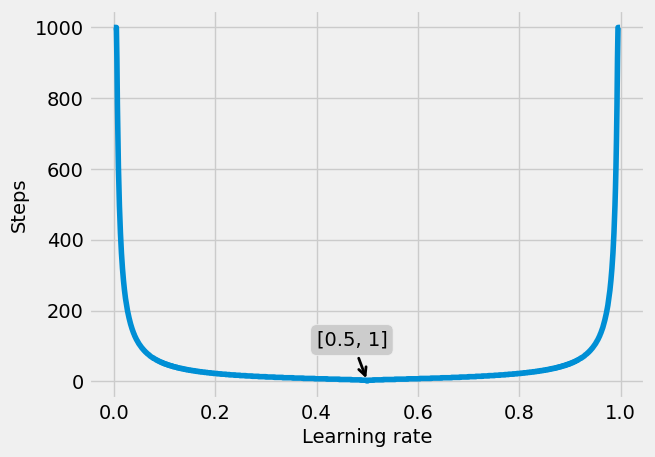

In [151]:
FILE_PREFIX = TASK_PREFIX + 'A_F1_'

def f(x):
    return x[0] ** 2 + x[1] ** 2

x = np.linspace(-50, 50, 120)
y = np.linspace(-75, 75, 120)
X, Y = np.meshgrid(x, y)
x0 = np.array([35, 50], dtype=float)

init()
constant_research_lr(0, 1e-3, max_iter=1000, filename=PATH_IMAGE + FILE_PREFIX + 'constant_research_lr', dpi=CNST_DPI_IMAGE)
# High quality:
constant_research_lr(0, 1e-3, max_iter=1000, filename=PATH_HQ + FILE_PREFIX + 'constant_research_lr_HQ', dpi=CNST_DPI_HQ)

#### Пример 2:

100%|██████████| 1000/1000 [00:00<00:00, 1094.73it/s]


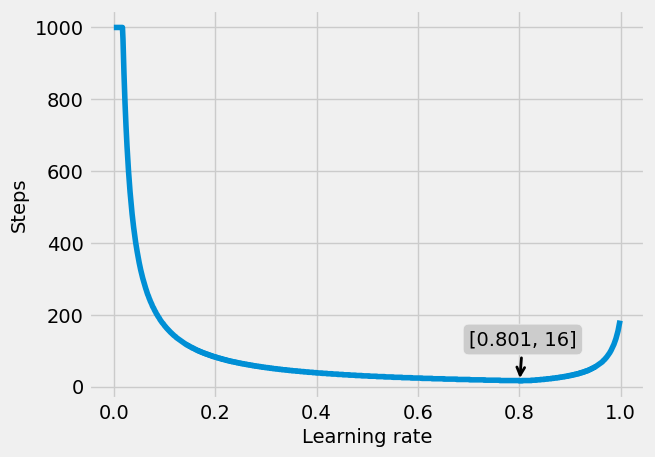

In [150]:
FILE_PREFIX = TASK_PREFIX + 'A_F2_'

def f(x):
	A = np.array([[0.7464451039232642, 1.0905399322509766], [-0.45261597812262555, 0.5415655721418664]])
	return (x.dot(A)).dot(x.T)

x = np.linspace(-50, 50, 120)
y = np.linspace(-75, 75, 120)
X, Y = np.meshgrid(x, y)
x0 = np.array([50, -75], dtype=float)

init()
constant_research_lr(0, 1e-3, max_iter=1000, filename=PATH_IMAGE + FILE_PREFIX + 'constant_research_lr', dpi=CNST_DPI_IMAGE)
# High quality:
constant_research_lr(0, 1e-3, max_iter=1000, filename=PATH_HQ + FILE_PREFIX + 'constant_research_lr_HQ', dpi=CNST_DPI_HQ)

### (b) сравните эффективность градиентного спуска с использованием одномерного поиска с точки зрения количества вычислений минимизируемой функции и ее градиентов;

#### Реализация:

In [134]:
def line_search_and_constant_research_step_size(minimum, lr_step_size=1e-04, max_iter=1000, eps=1e-6, filename='', filename_extension='.png', dpi=1024):
    step_size_values = np.arange(lr_step_size, 1, lr_step_size)

    table = {'constant': [],
            'dichotomy': []}
    
    global counter
    for lr_iter in tqdm(step_size_values):
        counter = 0
        gradient_descent_constant(f, x0, lr=lr_iter, num_iterations=max_iter, minimum=minimum, apply_min=True)
        table['constant'].append(counter)

        counter = 0
        gradient_descent_dichotomy(f, x0, step_size=lr_iter, num_iterations=max_iter, eps=eps, minimum=minimum, apply_min=True)
        table['dichotomy'].append(counter)

    min_constant_f_count_index = np.argmin(table['constant'])
    min_dichotomy_f_count_index = np.argmin(table['dichotomy'])

    plt.xlabel('Step size', fontsize=14)
    plt.ylabel('F(x) count', fontsize=14)
    plt.plot(step_size_values, table['constant'], label='constant: min - ' + str(table['constant'][min_constant_f_count_index]) + ' in ' + '%g' % step_size_values[min_constant_f_count_index])
    plt.plot(step_size_values, table['dichotomy'], label='dichotomy: min - ' + str(table['dichotomy'][min_dichotomy_f_count_index]) + ' in ' + '%g' % step_size_values[min_dichotomy_f_count_index])
    plt.legend(loc='upper left')

    if(filename != ''):
        plt.savefig(filename + filename_extension, dpi=dpi, bbox_inches=0, transparent=True)

    plt.show()

#### Пример 1: 

100%|██████████| 999/999 [00:03<00:00, 272.64it/s] 


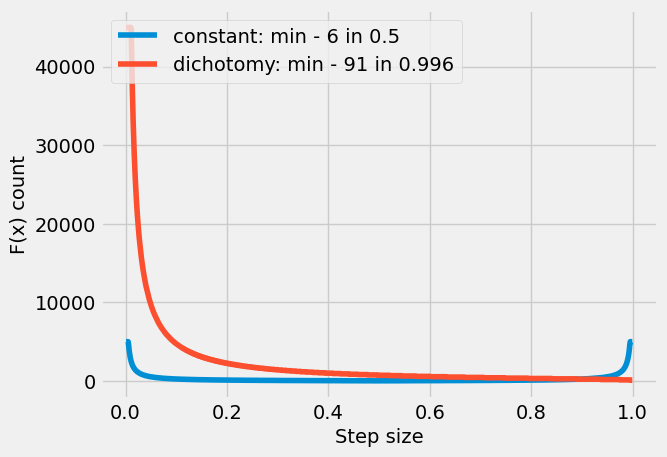

In [149]:
FILE_PREFIX = TASK_PREFIX + 'B_F1_'

counter = 0
def f(x):
    global counter
    counter += 1
    return x[0] ** 2 + x[1] ** 2

x = np.linspace(-50, 50, 120)
y = np.linspace(-75, 75, 120)
X, Y = np.meshgrid(x, y)
x0 = np.array([35, 50], dtype=float)

init()
line_search_and_constant_research_step_size(0, 1e-3, max_iter=1000, filename=PATH_IMAGE + FILE_PREFIX + 'line_search_and_constant_research_step_size', dpi=CNST_DPI_IMAGE)
# High quality:
line_search_and_constant_research_step_size(0, 1e-3, max_iter=1000, filename=PATH_HQ + FILE_PREFIX + 'line_search_and_constant_research_step_size_HQ', dpi=CNST_DPI_HQ)

#### Пример 2: 

100%|██████████| 999/999 [00:09<00:00, 101.28it/s]


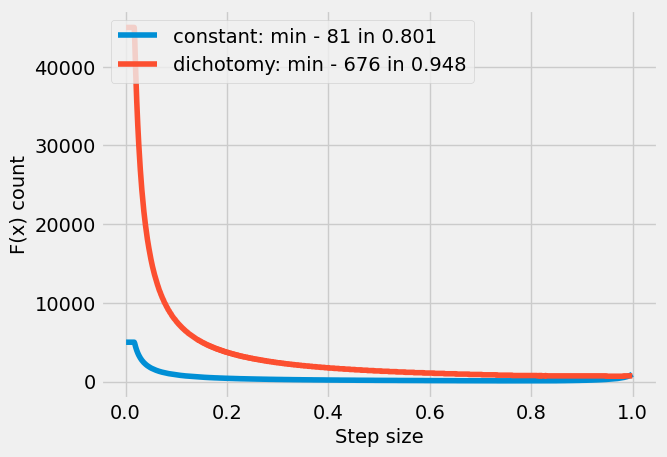

In [148]:
FILE_PREFIX = TASK_PREFIX + 'B_F2_'

counter = 0
def f(x):
    global counter
    counter += 1
    A = np.array([[0.7464451039232642, 1.0905399322509766], [-0.45261597812262555, 0.5415655721418664]])
    return (x.dot(A)).dot(x.T)

x = np.linspace(-50, 50, 120)
y = np.linspace(-75, 75, 120)
X, Y = np.meshgrid(x, y)
x0 = np.array([50, -75], dtype=float)

init()
line_search_and_constant_research_step_size(0, 1e-3, max_iter=1000, filename=PATH_IMAGE + FILE_PREFIX + 'line_search_and_constant_research_step_size', dpi=CNST_DPI_IMAGE)
# High quality:
line_search_and_constant_research_step_size(0, 1e-3, max_iter=1000, filename=PATH_HQ + FILE_PREFIX + 'line_search_and_constant_research_step_size_HQ', dpi=CNST_DPI_HQ)

### (c) исследуйте работу методов в зависимости от выбора начальной точки;

#### Реализация:

In [137]:
def get_count_step_constant(x, y):
    global f
    global x0
    x0 = np.array([x, y])
    return len(gradient_descent_constant(f, x0, lr=0.05, num_iterations=1000, minimum=0, apply_min=True))

def get_count_step_dichotomy(x, y):
    global f
    global x0
    x0 = np.array([x, y])
    return len(gradient_descent_dichotomy(f, x0, step_size=0.5, num_iterations=1000, minimum=0, apply_min=True))

#### Пример 1:

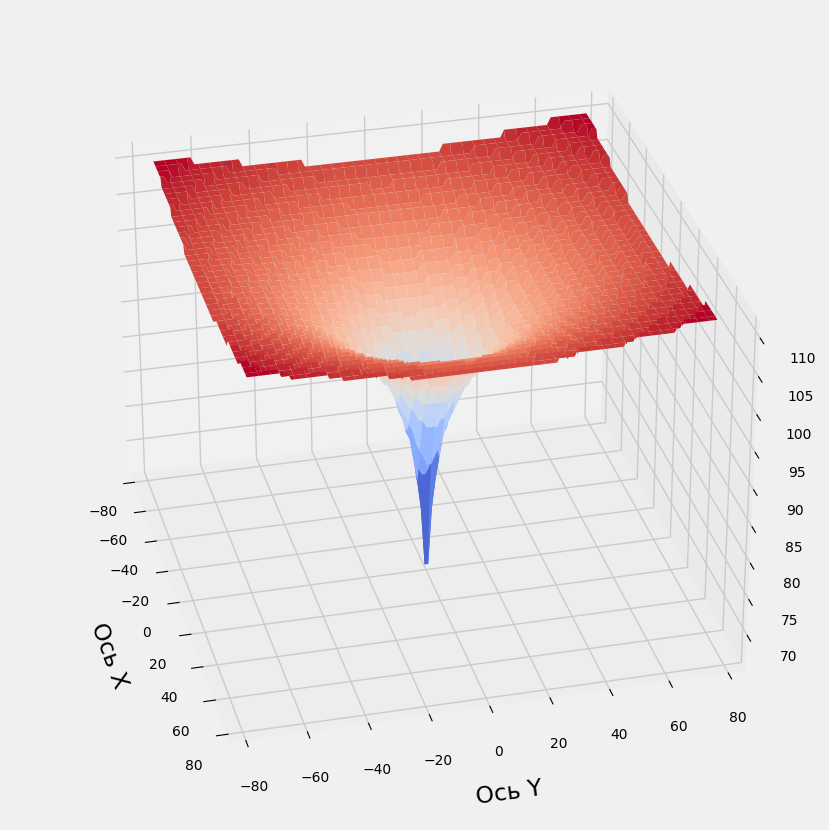

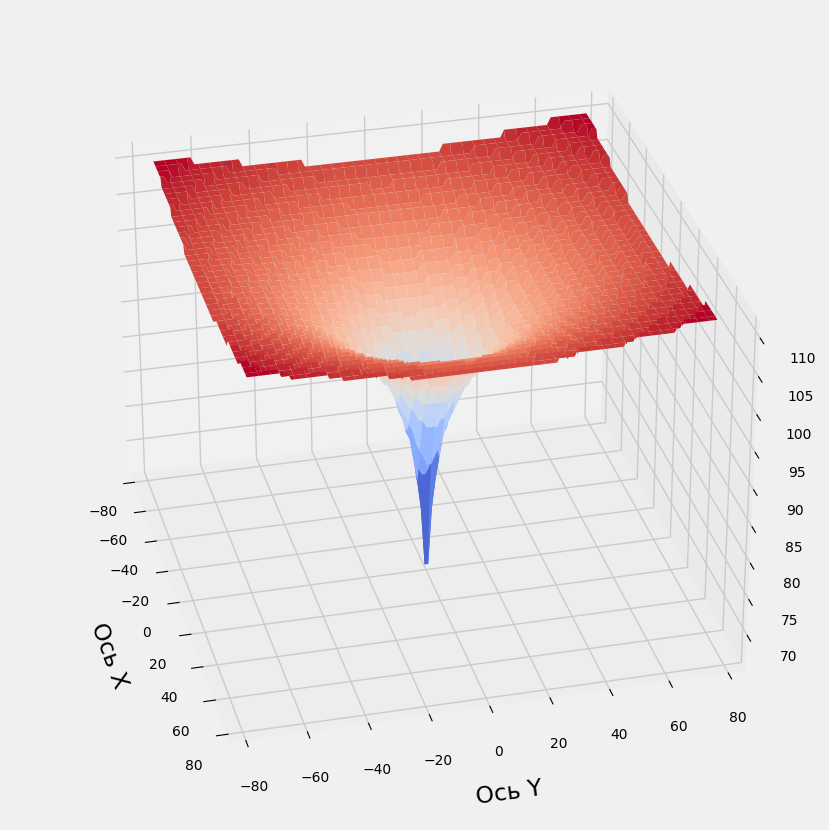

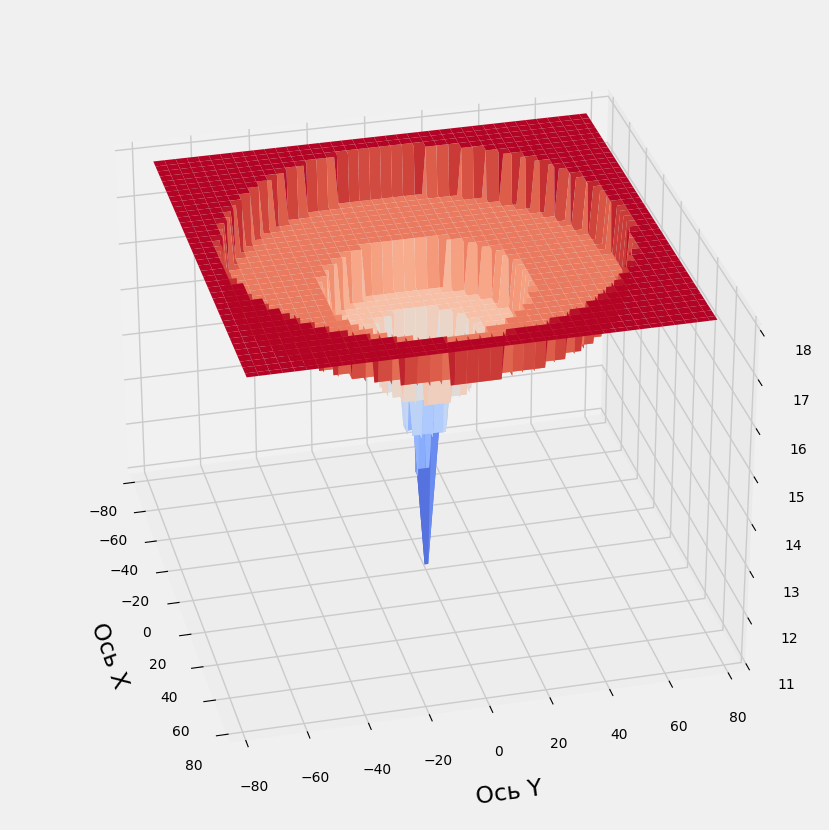

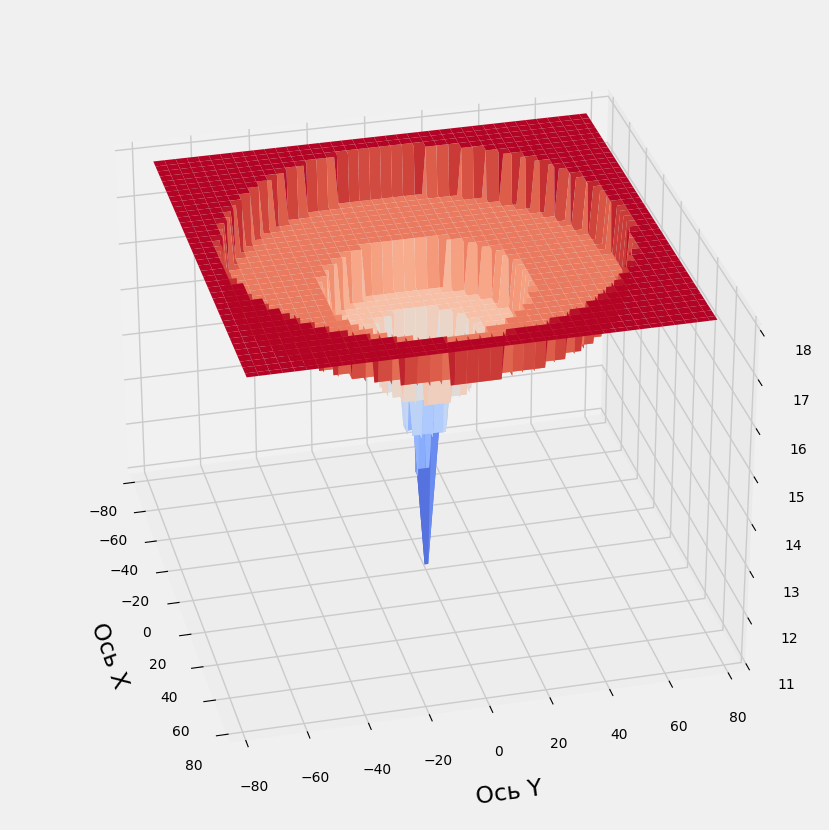

In [138]:
FILE_PREFIX = TASK_PREFIX + 'C_F1_'

def f(x):
    return x[0] ** 2 + x[1] ** 2

x = np.linspace(-75, 75, 120)
y = np.linspace(-75, 75, 120)
X, Y = np.meshgrid(x, y)

Z = np.vectorize(get_count_step_constant)(X, Y)
print_full_grad([], [], title='', elev=30, azim=-14, filename=PATH_IMAGE + FILE_PREFIX + 'steps_dependens_on_start_point_constant', dpi=CNST_DPI_IMAGE)
# High quality:
print_full_grad([], [], title='', elev=30, azim=-14, filename=PATH_HQ + FILE_PREFIX + 'steps_dependens_on_start_point_constant', dpi=CNST_DPI_HQ)

Z = np.vectorize(get_count_step_dichotomy)(X, Y)
print_full_grad([], [], title='', elev=30, azim=-14, filename=PATH_IMAGE + FILE_PREFIX + 'steps_dependens_on_start_point_dichotomy', dpi=CNST_DPI_IMAGE)
# High quality:
print_full_grad([], [], title='', elev=30, azim=-14, filename=PATH_HQ + FILE_PREFIX + 'steps_dependens_on_start_point_dichotomy', dpi=CNST_DPI_HQ)

#### Пример 2:

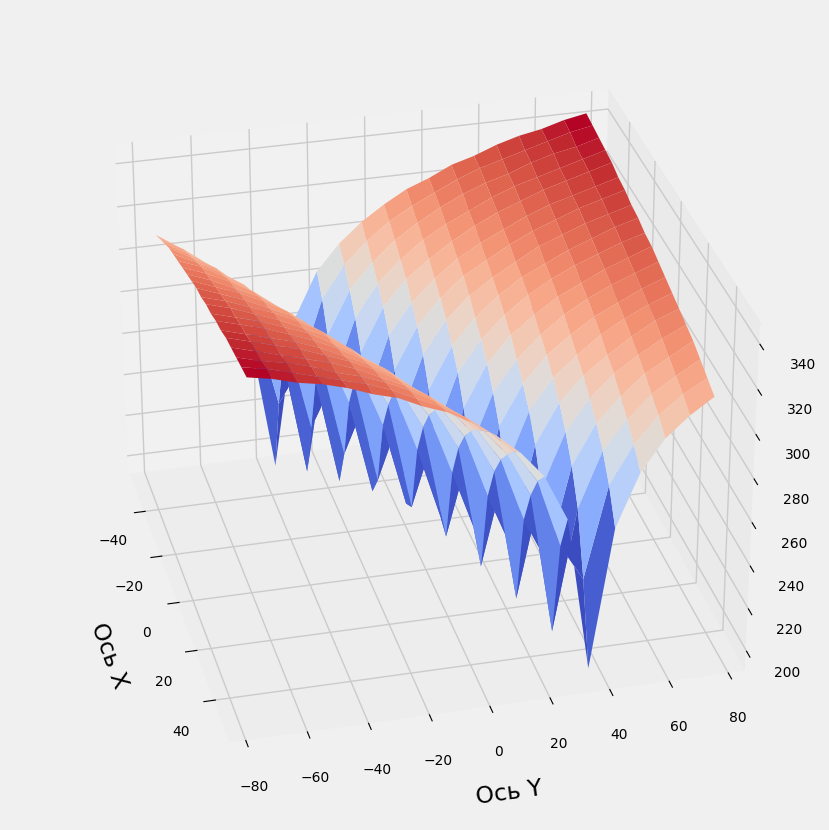

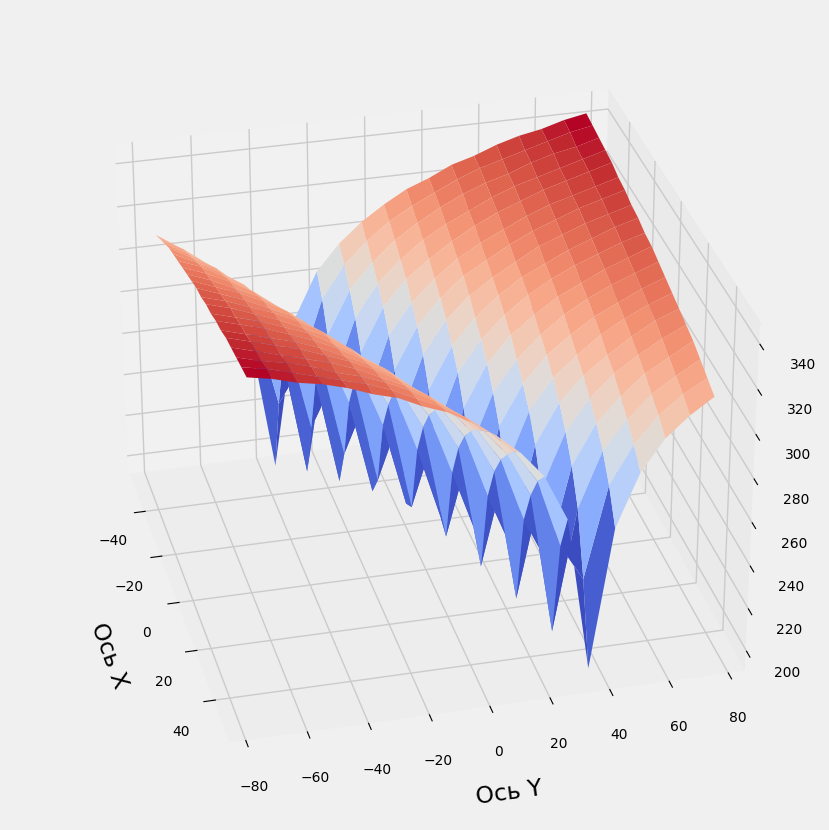

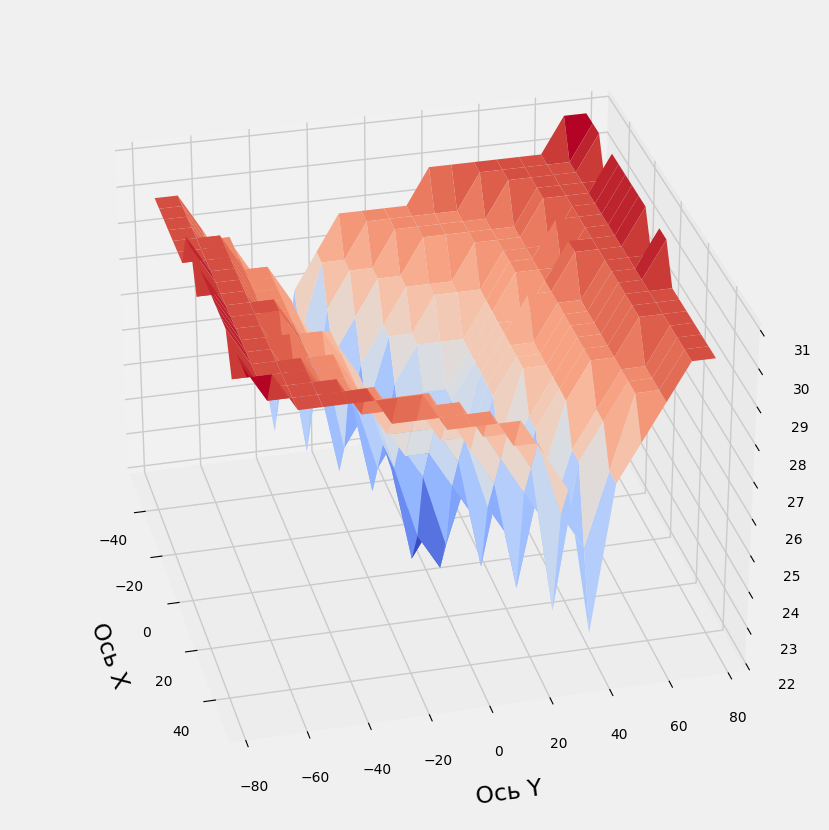

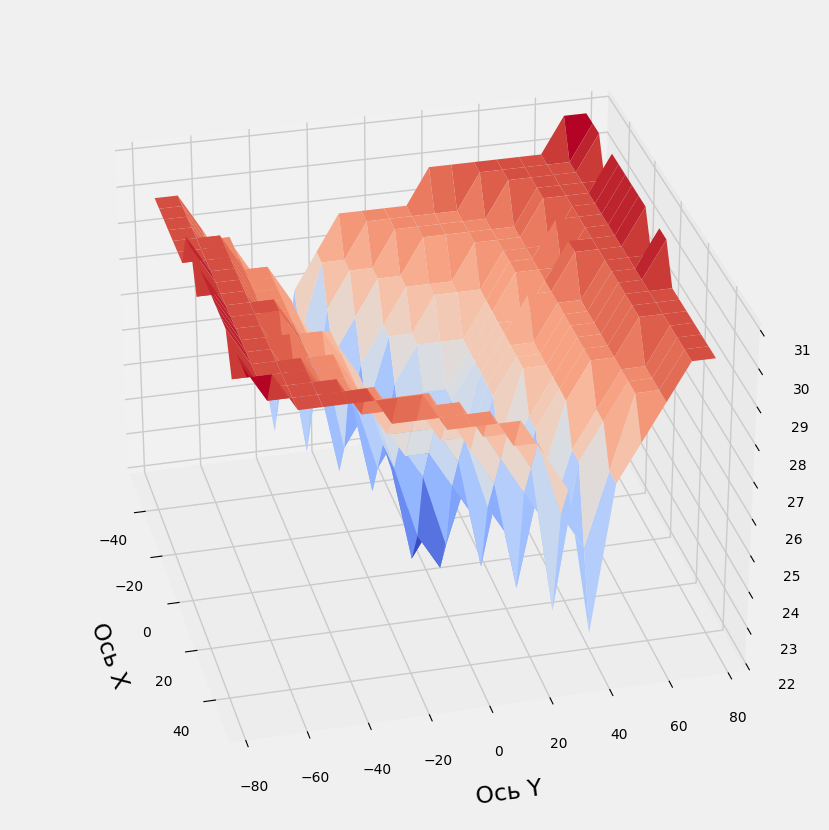

In [139]:
FILE_PREFIX = TASK_PREFIX + 'C_F2_'

def f(x):
	A = np.array([[0.7464451039232642, 1.0905399322509766], [-0.45261597812262555, 0.5415655721418664]])
	return (x.dot(A)).dot(x.T)

x = np.linspace(-50, 50, 20)
y = np.linspace(-75, 75, 20)
X, Y = np.meshgrid(x, y)

Z = np.vectorize(get_count_step_constant)(X, Y)
print_full_grad([], [], title='', elev=30, azim=-14, filename=PATH_IMAGE + FILE_PREFIX + 'steps_dependens_on_start_point_constant', dpi=CNST_DPI_IMAGE)
# High quality:
print_full_grad([], [], title='', elev=30, azim=-14, filename=PATH_HQ + FILE_PREFIX + 'steps_dependens_on_start_point_constant', dpi=CNST_DPI_HQ)

Z = np.vectorize(get_count_step_dichotomy)(X, Y)
print_full_grad([], [], title='', elev=30, azim=-14, filename=PATH_IMAGE + FILE_PREFIX + 'steps_dependens_on_start_point_dichotomy', dpi=CNST_DPI_IMAGE)
# High quality:
print_full_grad([], [], title='', elev=30, azim=-14, filename=PATH_HQ + FILE_PREFIX + 'steps_dependens_on_start_point_dichotomy', dpi=CNST_DPI_HQ)

### (e) в каждом случае нарисуйте графики с линиями уровня и траекториями методов;

#### Пример 1:

constant        ==>   0.000000 in [ -0.000000,  -0.000000]
dichotomy       ==>   0.000000 in [ -0.000000,  -0.000000]


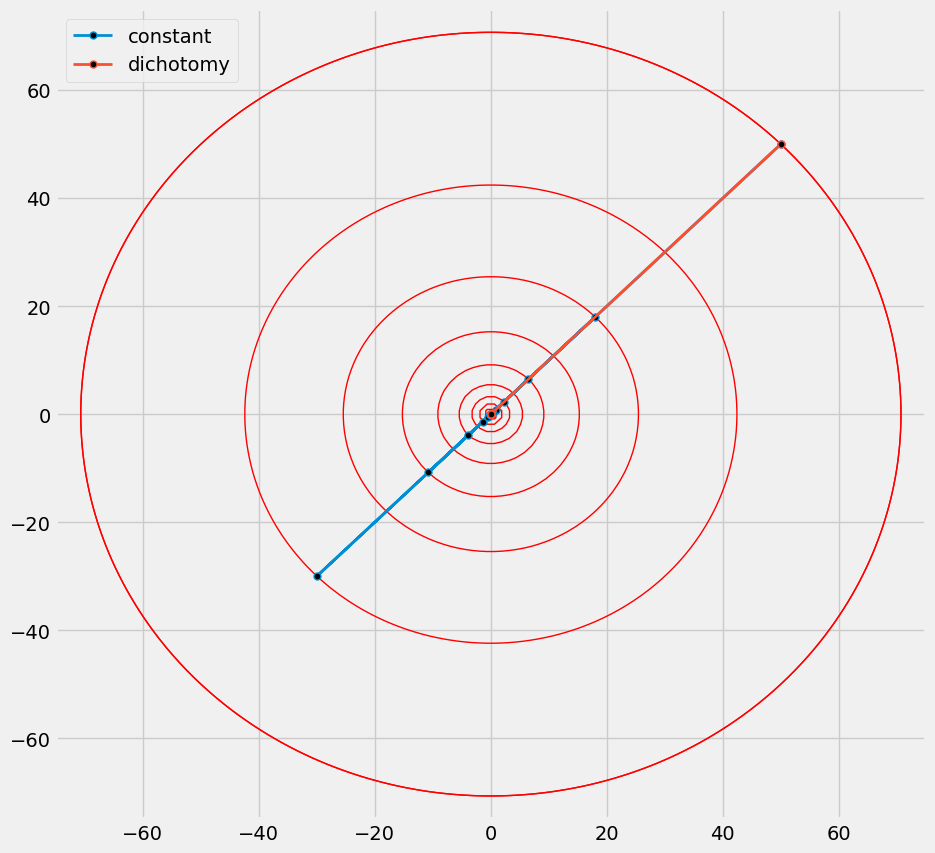

constant        ==>   0.000000 in [ -0.000000,  -0.000000]
dichotomy       ==>   0.000000 in [ -0.000000,  -0.000000]


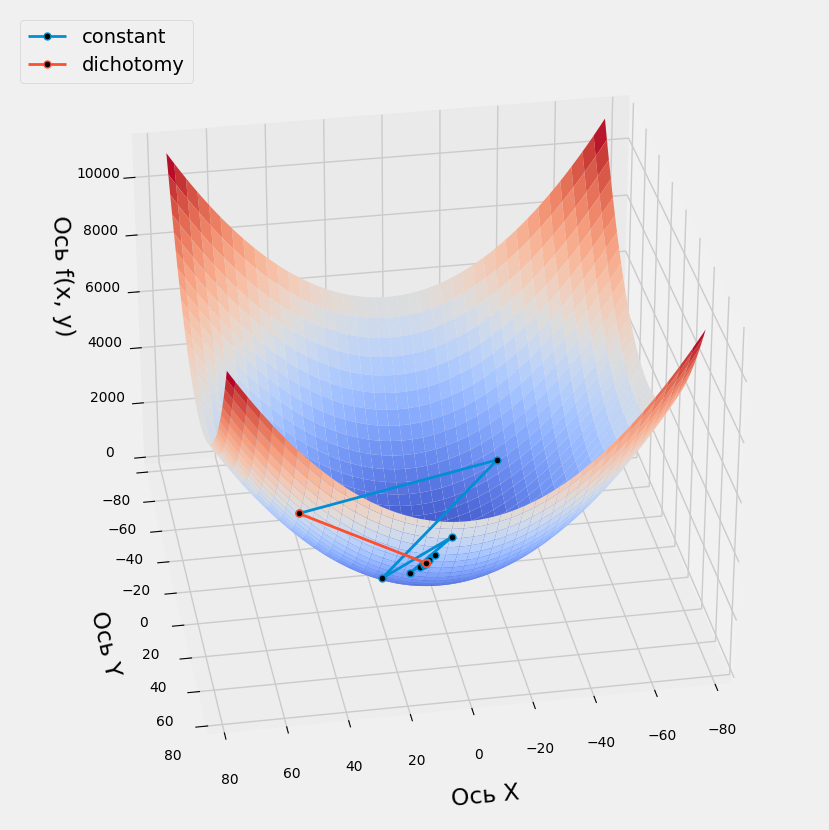

constant        ==>   0.000000 in [ -0.000000,  -0.000000]
dichotomy       ==>   0.000000 in [ -0.000000,  -0.000000]


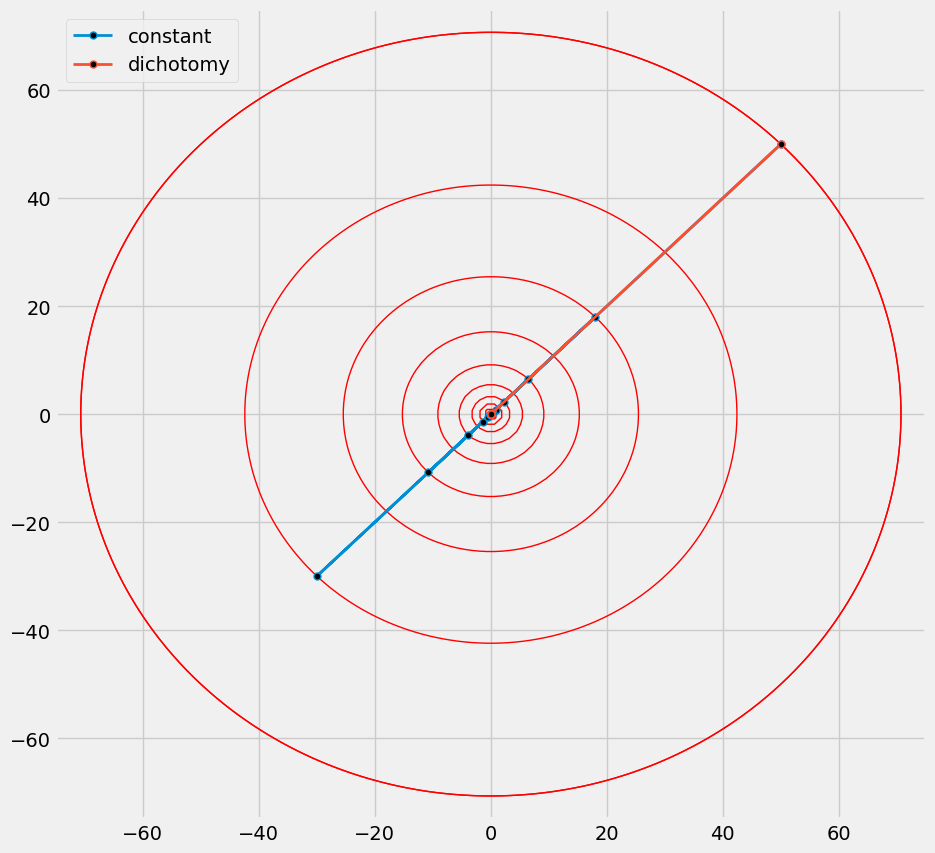

constant        ==>   0.000000 in [ -0.000000,  -0.000000]
dichotomy       ==>   0.000000 in [ -0.000000,  -0.000000]


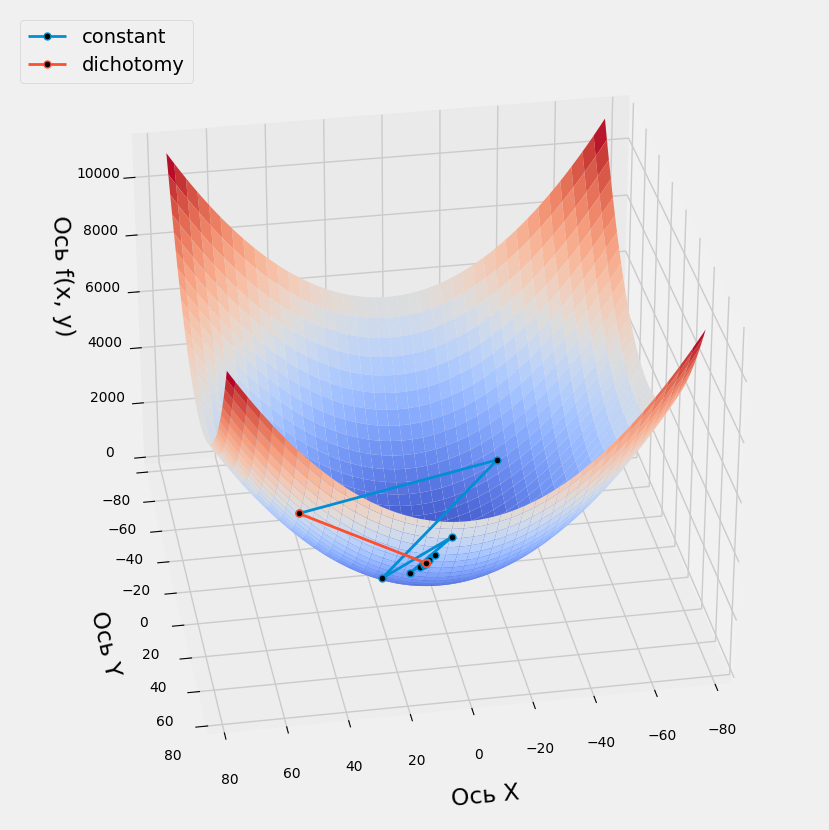

In [140]:
FILE_PREFIX = TASK_PREFIX + 'E_F1_'

def f(x):
    return x[0] ** 2 + x[1] ** 2

x = np.linspace(-75, 75, 120)
y = np.linspace(-75, 75, 120)
X, Y = np.meshgrid(x, y)
x0 = np.array([50, 50], dtype=float)

init()
num_iter = 60
result = [gradient_descent_constant(f, x0, lr=0.8, num_iterations=num_iter),
          gradient_descent_dichotomy(f, x0, step_size=1, num_iterations=num_iter)]
result_label = ['constant', 'dichotomy']

print_lines_grad(result, result_label, title='', filename=PATH_IMAGE + FILE_PREFIX + 'lines_grad_' + '_'.join(result_label), dpi=CNST_DPI_IMAGE)
print_full_grad(result, result_label, title='', filename=PATH_IMAGE + FILE_PREFIX + 'full_grad_' + '_'.join(result_label), dpi=CNST_DPI_IMAGE)
# High quality:
print_lines_grad(result, result_label, title='', filename=PATH_HQ + FILE_PREFIX + 'lines_grad_HQ_' + '_'.join(result_label), dpi=CNST_DPI_HQ)
print_full_grad(result, result_label, title='', filename=PATH_HQ + FILE_PREFIX + 'full_grad_HQ_' + '_'.join(result_label), dpi=CNST_DPI_HQ)

#### Пример 2:

constant        ==>   0.004670 in [  0.072429,  -0.099334]
dichotomy       ==>   0.000000 in [ -0.000000,  -0.000000]


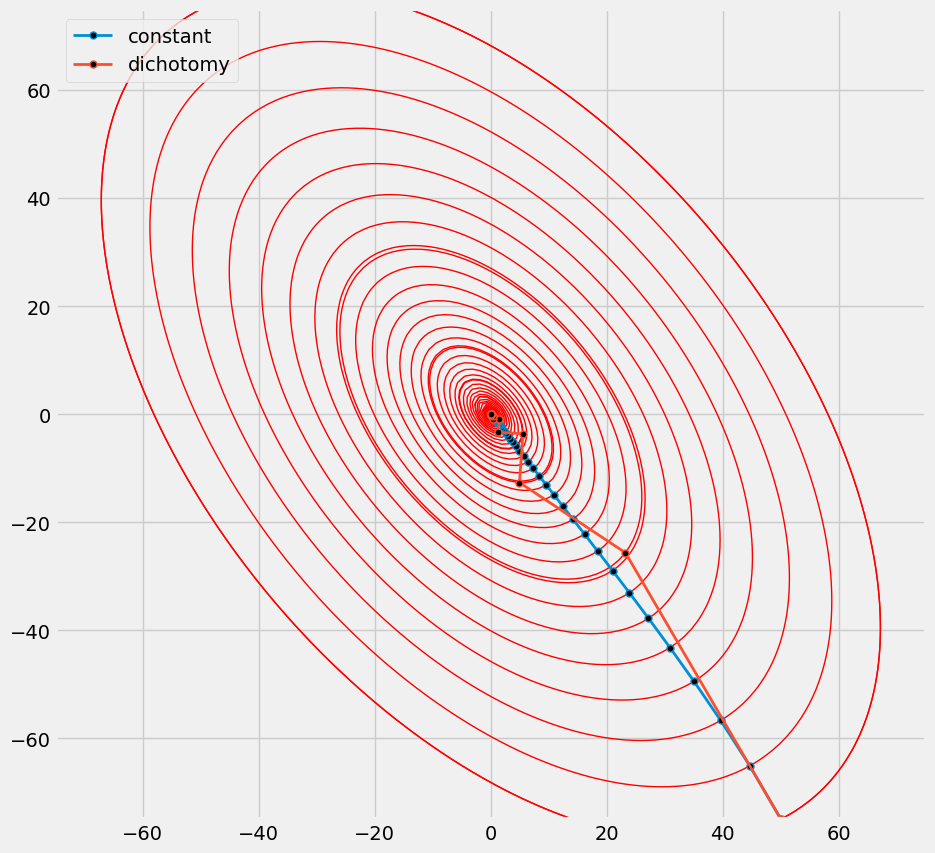

constant        ==>   0.004670 in [  0.072429,  -0.099334]
dichotomy       ==>   0.000000 in [ -0.000000,  -0.000000]


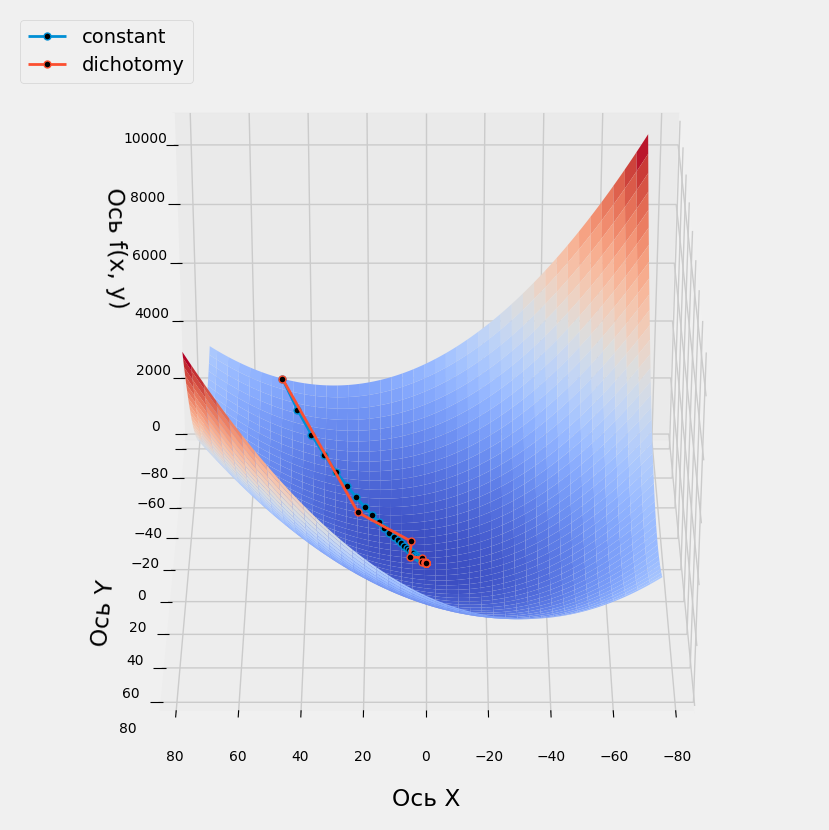

constant        ==>   0.004670 in [  0.072429,  -0.099334]
dichotomy       ==>   0.000000 in [ -0.000000,  -0.000000]


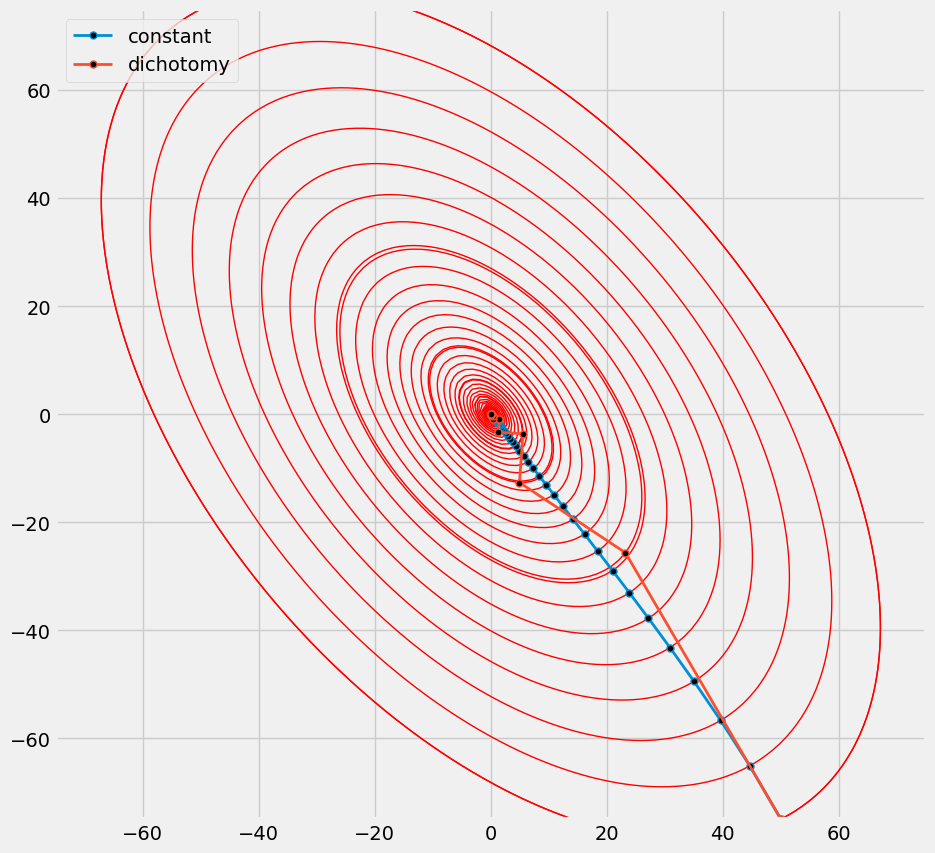

constant        ==>   0.004670 in [  0.072429,  -0.099334]
dichotomy       ==>   0.000000 in [ -0.000000,  -0.000000]


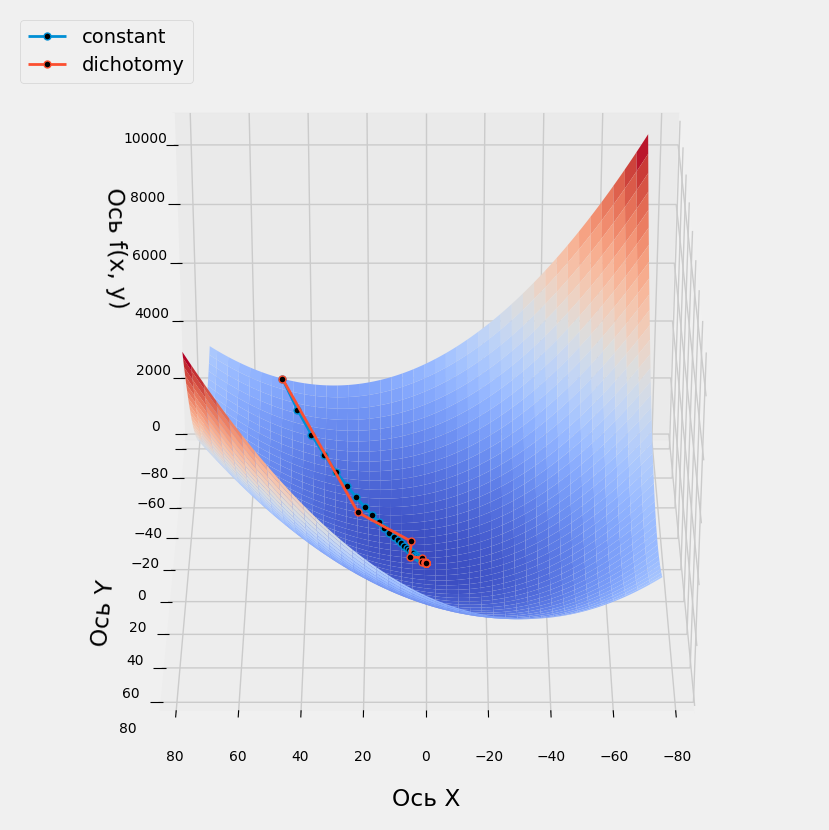

In [141]:
FILE_PREFIX = TASK_PREFIX + 'E_F2_'

def f(x):
	A = np.array([[0.7464451039232642, 1.0905399322509766], [-0.45261597812262555, 0.5415655721418664]])
	return (x.dot(A)).dot(x.T)

x = np.linspace(-75, 75, 120)
y = np.linspace(-75, 75, 120)
X, Y = np.meshgrid(x, y)
x0 = np.array([50, -75], dtype=float)

init()
num_iter = 50
result = [gradient_descent_constant(f, x0, lr=0.2, num_iterations=num_iter),
          gradient_descent_dichotomy(f, x0, step_size=1, num_iterations=num_iter)]
result_label = ['constant', 'dichotomy']


print_lines_grad(result, result_label, title='', filename=PATH_IMAGE + FILE_PREFIX + 'lines_grad_' + '_'.join(result_label), dpi=CNST_DPI_IMAGE)
print_full_grad(result, result_label, title='', azim=90, filename=PATH_IMAGE + FILE_PREFIX + 'full_grad_' + '_'.join(result_label), dpi=CNST_DPI_IMAGE)
# High quality:
print_lines_grad(result, result_label, title='', filename=PATH_HQ + FILE_PREFIX + 'lines_grad_HQ_' + '_'.join(result_label), dpi=CNST_DPI_HQ)
print_full_grad(result, result_label, title='', azim=90, filename=PATH_HQ + FILE_PREFIX + 'full_grad_HQ_' + '_'.join(result_label), dpi=CNST_DPI_HQ)